## 1.1 Detecting and Fixing Errors in dirty_data.csv 

General approach
Look for potential dirty data in the following areas:
- integrity constraints
- data entry error
- wrong categorical data
- violation of referential integrity
- duplicated data
- go against value range
- wrong encoding
- wrong representations
- wrong names and numbers

Import necessary libraries

In [125]:
# ! pip install networkx

In [2]:
import pandas as pd
import networkx as nx

In [127]:
dirty_data_path = "data\Group109_dirty_data.csv"
branch_path = r"data\branches.csv"
edges_path = "data\edges.csv"
nodes_path = r"data\nodes.csv"

dirty_df = pd.read_csv(dirty_data_path)
branch_df = pd.read_csv(branch_path)
edges_df = pd.read_csv(edges_path)
nodes_df = pd.read_csv(nodes_path)

In [128]:
branch_df

,branch_code,branch_name,branch_lat,branch_lon
0,NS,Nickolson,-37.773803,144.983647
1,TP,Thompson,-37.861835,144.905716
2,BK,Bakers,-37.815834,145.046450


In [129]:
dirty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 500 non-null    object 
 1   date                     500 non-null    object 
 2   time                     500 non-null    object 
 3   order_type               500 non-null    object 
 4   branch_code              500 non-null    object 
 5   order_items              500 non-null    object 
 6   order_price              500 non-null    float64
 7   customer_lat             500 non-null    float64
 8   customer_lon             500 non-null    float64
 9   customerHasloyalty?      500 non-null    int64  
 10  distance_to_customer_KM  500 non-null    float64
 11  delivery_fee             500 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 47.0+ KB


In [130]:
dirty_df.describe()

,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,480.712900,-30.753946,143.504403,0.102000,8.629274,13.877162
std,254.034843,25.337436,16.299630,0.302951,1.596279,2.378285
min,31.750000,-37.827188,-37.822231,0.000000,3.613000,5.646222
25%,300.625000,-37.818738,144.952786,0.000000,7.750500,12.660927
50%,434.250000,-37.811755,144.963914,0.000000,8.639500,13.849738
75%,633.250000,-37.804505,144.980037,0.000000,9.633500,15.229668
max,1361.500000,145.005221,145.015449,1.000000,13.735000,20.088572


In [131]:
dirty_df.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDX02948,2018-03-11,10:11:49,Breakfast,BK,"[('Cereal', 4), ('Eggs', 3), ('Coffee', 1), ('...",206.00,-37.805040,144.963243,0,7.615,14.403915
1,ORDC07988,2018-03-06,10:01:41,Breakfast,NS,"[('Coffee', 2), ('Cereal', 5), ('Eggs', 10), (...",437.00,-37.815989,144.983435,0,8.914,13.807773
2,ORDI00568,2018-07-05,14:05:04,Lunch,NS,"[('Fries', 6), ('Chicken', 5), ('Salad', 7), (...",507.40,-37.806281,144.941960,1,9.316,15.028384
3,ORDI06756,2018-04-23,11:43:05,Breakfast,NS,"[('Coffee', 3), ('Pancake', 6), ('Eggs', 3)]",234.00,-37.822259,144.946977,0,9.975,15.217270
4,ORDX01986,2018-04-29,11:53:14,Breakfast,BK,"[('Coffee', 6), ('Cereal', 1), ('Eggs', 2), ('...",134.25,-37.815950,144.986001,0,6.038,13.677500


As stated in the assignment brief, we will not be looking for any fixing values within the following columns as there are no errors in dirty data for them:
- `order_id`
- `time`
- the numeric quantity in `order_items`
- `delivery_fee`

- [x] check if dates, time is properly formatted
- [x] check if branch code is correct
- [ ] check if order price makes sense according to number of items ordered
- [ ] check if distance to customer is calculated properly in shortest distance
- [ ] check if customer_lat and customer_lon exist in nodes
- [x] check if order_type is correct according to time
- [ ] check if customer does / does not have loyalty according to delivery fee ()


Delivery fee is calculated using a different method for each branch.
The fee depends linearly (but in different ways for each branch) on:
a. weekend or weekday (1 or 0) - as a continuous variable
b. time of the day (morning 0, afternoon 1, evening 2) - as a continuous variable
c. distance between branch and customer


In [132]:
dirty_df['branch_code'].value_counts()

branch_code
TP    169
NS    163
BK    144
ns     11
tp      7
bk      6
Name: count, dtype: int64

From the output above, we can see that some of the branch codes have been inputted in the wrong representation. Instead of being inputted in all uppercase, some of the values are shown as lowercase. We will need to perform data transformation on this column to convert all values to uppercase letters

In [133]:
dirty_df['branch_code'] = dirty_df['branch_code'].apply(str.upper)

According to the assignment brief, all string date values in column `date` should be in the format YYYY-MM-DD. We can verify if this is the case by using `pd.to_datetime` function on the `date` column and see if all date values fit the format `%Y-%m-%d`

In [134]:
try:
    pd.to_datetime(dirty_df['date'], format='%Y-%m-%d', errors='raise')
except ValueError as e:
    print("Error occurred. Unable to convert the following date:")
    print(e)
else:
    print('No error')

Error occurred. Unable to convert the following date:
time data "06-10-2018" doesn't match format "%Y-%m-%d", at position 16. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.


As we can see, not all the date values are in the correct format. Therefore we will have to iterate through each date value and determine which one of the follow formats the date value can be in:
1. YYYY-MM-DD
2. DD-MM-YYYY
3. YYYY-DD-MM

In [135]:
for index, row in dirty_df.iterrows():
    new_row = pd.Series(row)

    # Check if date fits the format YYYY-MM-DD
    try:
        new_row = pd.to_datetime(row['date'], format='%Y-%m-%d')
    except:
        # If not, check if it fits the format YYYY-DD-MM
        try: 
            new_row = pd.to_datetime(row['date'], format='%Y-%d-%m')
        # Else, check if it fits the format DD-MM-YYYY
        except:
            new_row = pd.to_datetime(row['date'], format='%d-%m-%Y')
    dirty_df.at[index, 'date'] = new_row

dirty_df['date'] = pd.to_datetime(dirty_df['date'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')

Now we evaluate the `order_type` column. Since we know for certain that the time column does not have any errors in it, we can verify if the `order_type` is correct according to the time. The order should be the following according to the times:
- 08:00:00 - 12:00:00 = Breakfast
- 12:00:01 - 16:00:00 = Lunch
- 16:00:01 - 20:00:00 = Dinner

In [136]:
dirty_df['order_type'].value_counts()

order_type
Breakfast    170
Lunch        165
Dinner       165
Name: count, dtype: int64

To check if the correct order type has been inputted, we create the function `find_order-type`. It looks through each string time value in `time` column, converts this string into datetime format. Then we check the timestamp to see if it fits within the Breakfast, Lunch or Dinner time slots

In [137]:
def find_order_type(time):
    timestamp = pd.to_datetime(time, format='%H:%M:%S').time()
    if timestamp >= pd.to_datetime('08:00:00').time() and timestamp <= pd.to_datetime('12:00:00').time():
        return 'Breakfast'
    elif timestamp >= pd.to_datetime('12:00:01').time() and timestamp < pd.to_datetime('16:00:00').time():
        return 'Lunch'
    elif timestamp >= pd.to_datetime('16:00:01').time() and timestamp <= pd.to_datetime('20:00:00').time():
        return 'Dinner'
    else:
        return 'Error'

In [138]:
# output values where calculated order type does not match the order type in the dataset
dirty_df[dirty_df['time'].apply(find_order_type) != dirty_df['order_type']].head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
14,ORDC09610,2018-10-06,17:07:36,Lunch,NS,"[('Fish&Chips', 5), ('Shrimp', 2), ('Pasta', 4)]",393.0,-37.826028,144.984514,0,9.578,17.378357
19,ORDC06273,2018-09-05,16:06:45,Lunch,NS,"[('Pasta', 5), ('Shrimp', 10), ('Fish&Chips', ...",1361.5,-37.814936,144.927351,0,10.813,16.896152
20,ORDB10659,2018-04-20,11:32:57,Dinner,TP,"[('Eggs', 7), ('Coffee', 10), ('Cereal', 6), (...",597.5,-37.818900,144.952797,0,8.576,11.161592
37,ORDK01676,2018-03-16,10:21:58,Dinner,BK,"[('Eggs', 2), ('Pancake', 2)]",92.5,-37.801158,144.957692,0,8.326,13.278789
54,ORDB10190,2018-10-08,17:17:44,Breakfast,TP,"[('Fish&Chips', 2), ('Salmon', 2)]",152.0,-37.813657,144.957285,0,8.419,13.088105


As shown above, there are orders in which order type has been incorrectly inputted according to the time. We can fix this issue by performing the following

In [139]:
dirty_df['order_type'] = dirty_df['time'].apply(find_order_type)

In [140]:
dirty_df['order_type'].value_counts()

order_type
Dinner       170
Breakfast    166
Lunch        164
Name: count, dtype: int64

We determine if the branch and customer locations in `dirty_df` can be accurately found in the provided Graph in `nodes.csv`

In [141]:
# check if customer node exists
def check_customer_nodes(row):
    customer_node = nodes_df[(nodes_df['lat'] == row['customer_lat']) & (nodes_df['lon'] == row['customer_lon'])]

    if customer_node.empty:
        return True
    else:
        return False

# check if branch node exists
def check_branch_nodes(row):
    branch_lat = branch_df[branch_df['branch_code'] == row['branch_code']]['branch_lat'].values[0]
    branch_lon = branch_df[branch_df['branch_code'] == row['branch_code']]['branch_lon'].values[0]

    branch_node = nodes_df[(nodes_df['lat'] == branch_lat) & (nodes_df['lon'] == branch_lon)]

    if branch_node.empty:
        return True 
    else:
        return False

In [142]:
# Retrieve the number of rows where the customer node does not exist in the nodes.csv file
dirty_df.apply(check_branch_nodes, axis=1).sum()

0

From the above results, we can see that all the branch nodes are accounted for and each node exists in the provided graph

In [143]:
dirty_df.apply(check_customer_nodes, axis=1).sum()

41

When checking for customer nodes, it is evident that there are 41 instances of orders where we are unable to identify the node in the graph according to the provided customer longitude and latitude values. To investigate further into the cause of this issue, let's output the first 15 instances where this is the case.

In [144]:
dirty_df[dirty_df.apply(check_customer_nodes, axis=1)][['customer_lat', 'customer_lon']].head(15)

,customer_lat,customer_lon
5,37.814994,144.960538
7,37.816395,144.938170
12,37.816482,144.964894
25,37.824000,144.953766
35,37.811124,145.001788
38,37.799866,145.002800
45,37.814037,144.985480
49,37.813155,144.968360
52,37.804832,144.950241
53,37.812135,144.962341


From the outputted data above, we can see 2 prominent errors within the data:
1. <b>There are some instances in which customer latitude has a missing negative symbol at the front. </b>

Take the row at index 5 for example where latitude and longitude are 37.814994 and 144.960538 respectively. If we look at the `nodes.csv` file:

In [145]:
index = 5
# modify latitude by multiplying it by -1
lat = dirty_df.loc[index,]['customer_lat'] * -1
lon = dirty_df.loc[index,]['customer_lon']

# check if the modified latitude exists in the nodes.csv file
nodes_df[(nodes_df['lat'] == lat) & (nodes_df['lon'] == lon)]

,node,lat,lon
3793,6167489464,-37.814994,144.960538


As shown above, the following node exists in the graph when the latitude value is included with a negative value.


2. <b>There are some instance in which customer longitude and customer latitude are placed incorrectly and have been swapped with one another</b>

Take row at index 135 for example where latitude and longitude are 145.005221 and -37.817570 respectively. It is evident that these have been inputted incorrectly and the values have swapped over.

In [146]:
index = 135
# modify latitude by multiplying it by -1
lat = dirty_df.loc[index,]['customer_lon']
lon = dirty_df.loc[index,]['customer_lat']

# check if the modified latitude exists in the nodes.csv file
nodes_df[(nodes_df['lat'] == lat) & (nodes_df['lon'] == lon)]

,node,lat,lon
9191,1463620803,-37.81757,145.005221


As shown above, the following node exists in the graph when the customer latitude and longitude values are swapped over.

We fix the issue with customer longitude and latitude values using the following custom function `find_customer_node` which first tries to find the node of the customer based on the given latitude and longitude values. If it is unable to do so, we try the following approaches next:
1. Multiply the latitude value by negative and check to see if these coordinates exist in `nodes_df`. Else;
2. Swap the longitude and latitude values and check to see if these coordinates exist in `nodes_df`

If none of these approaches allow us to find a node, we will raise a `ValueError`

In [147]:
def calc_customer_node(row):
    cus_lat = row['customer_lat']
    cus_lon = row['customer_lon']
    customer_node = nodes_df[(nodes_df['lat'] == cus_lat) & (nodes_df['lon'] == cus_lon)]

    # If the customer node does not exist, check for misinput of latitude and longitude values
    if customer_node.empty:
        # multiply the latitude by -1 
        customer_node = nodes_df[(nodes_df['lat'] == -cus_lat) & (nodes_df['lon'] == cus_lon)]
        # If the customer node still does not exist, try swapping the latitude and longitude values
        if customer_node.empty:
            customer_node = nodes_df[(nodes_df['lat'] == cus_lon) & (nodes_df['lon'] == cus_lat)]

    # If the customer node still does not exist, raise an error
    if customer_node.empty:
        raise ValueError("Customer node does not exist in the nodes.csv file")
    
    return customer_node.iloc[0]['lat'], customer_node.iloc[0]['lon']


In [148]:
dirty_df['customer_coords'] = dirty_df.apply(calc_customer_node, axis=1)
dirty_df[['customer_lat', 'customer_lon']] = pd.DataFrame(dirty_df['customer_coords'].to_list(), index=dirty_df.index)

dirty_df.drop(columns=['customer_coords'], inplace=True)

In [149]:
dirty_df.apply(check_customer_nodes, axis=1).sum()

0

When we run `check_customer_nodes` again we can see that all of the coordinates can be accounted for and found in the `nodes.csv` file

Now we check if `distance_to_customer_KM` is correct. To start with this, we utilise `Graph()` function from `networkx` library to construct a Graph based on the nodes, edges provided by the Assignment brief in `nodes.csv` and `edges.csv` respectively

In [150]:
G = nx.Graph()
G.add_nodes_from(nodes_df['node'])
for index, row in edges_df.iterrows():
    G.add_edge(row['u'], row['v'], weight=row['distance(m)'])

In [151]:
edges_df

,Unnamed: 0,u,v,distance(m),street type,speed(km/h)
0,0,711327755,711332946,58.0,1,15.0
1,2,711327755,55725841,15.0,2,20.0
2,3,711327755,711327760,165.0,1,15.0
3,4,711327756,703557073,4.0,0,10.0
4,5,711327756,711332946,8.0,1,15.0
...,...,...,...,...,...,...
42219,50006,1449431614,1449431244,16.0,2,20.0
42220,50007,1449431614,1449431574,17.0,2,20.0
42221,50008,1449431622,60095777,196.0,1,15.0
42222,50009,1449431623,1449431622,19.0,1,15.0


In [152]:

def find_branch_node(row):
    branch_lat = branch_df[branch_df['branch_code'] == row['branch_code']]['branch_lat'].values[0]
    branch_lon = branch_df[branch_df['branch_code'] == row['branch_code']]['branch_lon'].values[0]

    branch_node = nodes_df[(nodes_df['lat'] == branch_lat) & (nodes_df['lon'] == branch_lon)]

    return branch_node

def find_shortest_path(row):
    cus_lat = row['customer_lat']
    cus_lon = row['customer_lon']
    customer_node = nodes_df[(nodes_df['lat'] == cus_lat) & (nodes_df['lon'] == cus_lon)]
    
    branch_node = find_branch_node(row)

    # Find the shortest path between the customer node and the branch node
    try:
        # calculates the shortest path using djikstra's algorithm in M
        shortest_path = nx.shortest_path_length(G, source=customer_node['node'].values[0], target=branch_node['node'].values[0], weight='weight')

        # calculate to KM
        shortest_path = shortest_path/1000
    except nx.NetworkXNoPath:
        raise ValueError("No path exists between the customer node and the branch node")
    
    return shortest_path

In [153]:
dirty_df['shortest_path'] = dirty_df.apply(find_shortest_path, axis=1)

In [154]:
dirty_df[dirty_df['distance_to_customer_KM'] != dirty_df['shortest_path']][['distance_to_customer_KM', 'shortest_path']].head()

,distance_to_customer_KM,shortest_path
1,8.914,8.624
11,8.330,7.699
15,8.667,7.938
18,8.245,8.787
22,5.435,11.912


In [155]:
dirty_df['distance_to_customer_KM'] = dirty_df['shortest_path']
dirty_df.drop(columns=['shortest_path'], inplace=True)

In [120]:
dirty_df

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDX02948,2018-03-11,10:11:49,Breakfast,BK,"[('Cereal', 4), ('Eggs', 3), ('Coffee', 1), ('...",206.00,-37.805040,144.963243,0,7.615,14.403915
1,ORDC07988,2018-03-06,10:01:41,Breakfast,NS,"[('Coffee', 2), ('Cereal', 5), ('Eggs', 10), (...",437.00,-37.815989,144.983435,0,8.624,13.807773
2,ORDI00568,2018-07-05,14:05:04,Lunch,NS,"[('Fries', 6), ('Chicken', 5), ('Salad', 7), (...",507.40,-37.806281,144.941960,1,9.316,15.028384
3,ORDI06756,2018-04-23,11:43:05,Breakfast,NS,"[('Coffee', 3), ('Pancake', 6), ('Eggs', 3)]",234.00,-37.822259,144.946977,0,9.975,15.217270
4,ORDX01986,2018-04-29,11:53:14,Breakfast,BK,"[('Coffee', 6), ('Cereal', 1), ('Eggs', 2), ('...",134.25,-37.815950,144.986001,0,6.038,13.677500
...,...,...,...,...,...,...,...,...,...,...,...,...
495,ORDZ08211,2018-03-27,10:42:15,Breakfast,NS,"[('Coffee', 3), ('Pancake', 6), ('Cereal', 1),...",409.00,-37.809194,144.973066,0,7.240,12.114681
496,ORDA06488,2018-09-23,16:47:19,Dinner,BK,"[('Salmon', 1), ('Pasta', 7), ('Shrimp', 6), (...",802.50,-37.805559,144.945085,0,9.100,19.245383
497,ORDY05487,2018-07-06,14:05:04,Lunch,TP,"[('Burger', 3), ('Steak', 7)]",408.00,-37.811246,145.000438,0,11.050,14.272925
498,ORDB04585,2018-09-21,16:47:19,Dinner,TP,"[('Pasta', 1), ('Shrimp', 9), ('Fish&Chips', 1...",945.50,-37.820320,144.957726,1,7.933,12.252722


In [122]:
df = dirty_df
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'])

# Calculate weekday/weekend as a continuous variable in the range [0, 1]
df['weekend'] = df['date'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)

# Calculate time of day as a continuous variable
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute
df['time_of_day'] = (df['hour'] * 60 + df['minute']) / (24 * 60)  # Normalize to [0, 1]
df

C:\Users\rrau0\AppData\Local\Temp\ipykernel_63284\1098007690.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['time'])


,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,weekend,hour,minute,time_of_day
0,ORDX02948,2018-03-11,2024-05-16 10:11:49,Breakfast,BK,"[('Cereal', 4), ('Eggs', 3), ('Coffee', 1), ('...",206.00,-37.805040,144.963243,0,7.615,14.403915,1,10,11,0.424306
1,ORDC07988,2018-03-06,2024-05-16 10:01:41,Breakfast,NS,"[('Coffee', 2), ('Cereal', 5), ('Eggs', 10), (...",437.00,-37.815989,144.983435,0,8.624,13.807773,0,10,1,0.417361
2,ORDI00568,2018-07-05,2024-05-16 14:05:04,Lunch,NS,"[('Fries', 6), ('Chicken', 5), ('Salad', 7), (...",507.40,-37.806281,144.941960,1,9.316,15.028384,0,14,5,0.586806
3,ORDI06756,2018-04-23,2024-05-16 11:43:05,Breakfast,NS,"[('Coffee', 3), ('Pancake', 6), ('Eggs', 3)]",234.00,-37.822259,144.946977,0,9.975,15.217270,0,11,43,0.488194
4,ORDX01986,2018-04-29,2024-05-16 11:53:14,Breakfast,BK,"[('Coffee', 6), ('Cereal', 1), ('Eggs', 2), ('...",134.25,-37.815950,144.986001,0,6.038,13.677500,1,11,53,0.495139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,ORDZ08211,2018-03-27,2024-05-16 10:42:15,Breakfast,NS,"[('Coffee', 3), ('Pancake', 6), ('Cereal', 1),...",409.00,-37.809194,144.973066,0,7.240,12.114681,0,10,42,0.445833
496,ORDA06488,2018-09-23,2024-05-16 16:47:19,Dinner,BK,"[('Salmon', 1), ('Pasta', 7), ('Shrimp', 6), (...",802.50,-37.805559,144.945085,0,9.100,19.245383,1,16,47,0.699306
497,ORDY05487,2018-07-06,2024-05-16 14:05:04,Lunch,TP,"[('Burger', 3), ('Steak', 7)]",408.00,-37.811246,145.000438,0,11.050,14.272925,0,14,5,0.586806
498,ORDB04585,2018-09-21,2024-05-16 16:47:19,Dinner,TP,"[('Pasta', 1), ('Shrimp', 9), ('Fish&Chips', 1...",945.50,-37.820320,144.957726,1,7.933,12.252722,0,16,47,0.699306


In [124]:
df = dirty_df
morning_range = range(6, 12)  # 6:00 to 11:59
afternoon_range = range(12, 18)  # 12:00 to 17:59
evening_range = range(18, 24)  # 18:00 to 23:59
def map_time_of_day(hour):
    if hour in morning_range:
        return hour / 24  # Scale to [0, 1]
    elif hour in afternoon_range:
        return (hour - 12) / 24 + 0.5  # Scale to [0.5, 1]
    elif hour in evening_range:
        return (hour - 18) / 24 + 0.75  # Scale to [0.75, 1]
    else:
        return hour / 24  # Scale to [0, 1] for any other time
df['time'] = pd.to_datetime(df['time'])
df['time_of_day'] = df['time'].dt.hour.apply(map_time_of_day)

df['date'] = pd.to_datetime(df['date'])

df['weekend'] = df['date'].dt.dayofweek / 6
# df['time_of_day'] = df['time'].dt.hour + df['time'].dt.minute / 60
print(df[['date', 'time', 'weekend', 'time_of_day', 'distance_to_customer_KM']])


          date                time   weekend  time_of_day  \
0   2018-03-11 2024-05-16 10:11:49  1.000000     0.416667   
1   2018-03-06 2024-05-16 10:01:41  0.166667     0.416667   
2   2018-07-05 2024-05-16 14:05:04  0.500000     0.583333   
3   2018-04-23 2024-05-16 11:43:05  0.000000     0.458333   
4   2018-04-29 2024-05-16 11:53:14  1.000000     0.458333   
..         ...                 ...       ...          ...   
495 2018-03-27 2024-05-16 10:42:15  0.166667     0.416667   
496 2018-09-23 2024-05-16 16:47:19  1.000000     0.666667   
497 2018-07-06 2024-05-16 14:05:04  0.666667     0.583333   
498 2018-09-21 2024-05-16 16:47:19  0.666667     0.666667   
499 2018-01-30 2024-05-16 08:50:42  0.166667     0.333333   

     distance_to_customer_KM  
0                      7.615  
1                      8.624  
2                      9.316  
3                      9.975  
4                      6.038  
..                       ...  
495                    7.240  
496                

In [195]:
# import pandas as pdimport pandas as pd
from sklearn.linear_model import LinearRegression

def fit_linear_model_for_branch(branch_code, df):
    branch_data = df[df['branch_code'] == branch_code]

    X = branch_data[['weekend', 'time_of_day', 'distance_to_customer_KM']]
    y = branch_data['delivery_fee']

    model = LinearRegression()
    model.fit(X, y)

    # Calculate R-squared score
    r2_score = model.score(X, y)

    return model, r2_score

models = {}
r2_scores = {}

for branch_code in df['branch_code'].unique():
    model, r2_score = fit_linear_model_for_branch(branch_code, df)
    models[branch_code] = model
    r2_scores[branch_code] = r2_score
    branch_data = df[df['branch_code'] == branch_code]
    X = branch_data[['weekend', 'time_of_day', 'distance_to_customer_KM']]
    df.loc[df['branch_code'] == branch_code, 'predicted_delivery_fee'] = model.predict(X)
    
df['adjusted_predicted_delivery_fee'] = df['predicted_delivery_fee']
df.loc[df['customerHasloyalty?'] == 1, 'adjusted_predicted_delivery_fee'] *= 0.5

comparison = df[['delivery_fee', 'predicted_delivery_fee', 'adjusted_predicted_delivery_fee']]

print("Comparison of Delivery Fees:")
print(comparison)

print("\nR-squared accuracy for each branch's predicted model:")
for branch_code, r2_score in r2_scores.items():
    print(f"Branch {branch_code}: R-squared = {r2_score}")
from sklearn.linear_model import LinearRegression


def fit_linear_model_for_branch(branch_code, df):

    branch_data = df[df['branch_code'] == branch_code]

    X = branch_data[['weekend', 'time_of_day', 'distance_to_customer_KM']]
    y = branch_data['delivery_fee']

    model = LinearRegression()
    model.fit(X, y)

    return model

models = {}
for branch_code in df['branch_code'].unique():
    models[branch_code] = fit_linear_model_for_branch(branch_code, df)

r2_scores = {}
for branch_code, model in models.items():
    branch_data = df[df['branch_code'] == branch_code]
    X = branch_data[['weekend', 'time_of_day', 'distance_to_customer_KM']]
    df.loc[df['branch_code'] == branch_code, 'predicted_delivery_fee'] = model.predict(X)
    

df['adjusted_predicted_delivery_fee'] = df['predicted_delivery_fee']
df.loc[df['customerHasloyalty?'] == 1, 'adjusted_predicted_delivery_fee'] *= 0.5

comparison = df[['delivery_fee', 'predicted_delivery_fee', 'adjusted_predicted_delivery_fee']]
print(comparison)


Comparison of Delivery Fees:
     delivery_fee  predicted_delivery_fee  adjusted_predicted_delivery_fee
0       14.403915               14.527524                        14.527524
1       13.807773               12.905322                        12.905322
2       15.028384               15.083440                         7.541720
3       15.217270               13.990286                        13.990286
4       13.677500               13.255744                        13.255744
..            ...                     ...                              ...
495     12.114681               11.729400                        11.729400
496     19.245383               17.820029                        17.820029
497     14.272925               14.457789                        14.457789
498     12.252722               13.182134                         6.591067
499     11.306446                9.810548                         9.810548

[500 rows x 3 columns]

R-squared accuracy for each branch's predicted

In [52]:
from sklearn.metrics import r2_score

for branch_code, model in models.items():
    branch_data = df[df['branch_code'] == branch_code]
    X = branch_data[['weekend', 'time_of_day', 'distance_to_customer_KM']]
    y_true = branch_data['delivery_fee']
    y_pred = model.predict(X)
    
    r2 = r2_score(y_true, y_pred)
    print(f"Branch {branch_code} - R2 Score: {r2}")


Branch BK - R2 Score: 0.8077010674448935
Branch NS - R2 Score: 0.48601203503606083
Branch TP - R2 Score: 0.5494535961839073


## Detecting and Removing Outlier Rows in outlier_data.csv

In [3]:
outlier_data_path = "data\Group109_outlier_data.csv"
df_outlier = pd.read_csv(outlier_data_path) # Reading the Data file path 


In [205]:
df_outlier.shape
# df_outlier.head()

(500, 12)

<Figure size 1000x600 with 0 Axes>

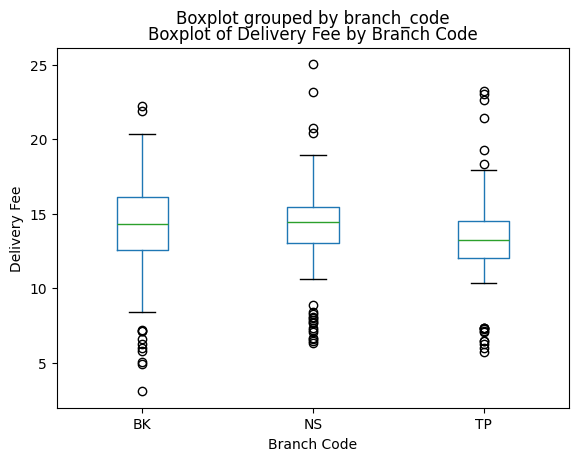

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
df_outlier.boxplot(column='delivery_fee', by='branch_code', grid=False) #Creatign a boxplot for delivery_fee based on the branch_code
plt.title('Boxplot of Delivery Fee by Branch Code')
plt.xlabel('Branch Code')
plt.ylabel('Delivery Fee')
plt.xticks()
plt.show()

The distribution of delivery fees among the three branch codes—BK, NS, and TP—is shown in the boxplot. The median delivery fee for each branch is roughly 14–15, with BK and NS having somewhat higher medians than TP. The interquartile range (IQR) of delivery_fee, varies from 11 to 18 for BK, 12 to 17 for NS, and 11 to 16 for TP. This range is largely stable between branches. For every branch, the whiskers, which show the range within 1.5 times the IQR from the quartiles, roughly span from 8 to 20. Interestingly, there are a considerable number of outliers in every branch. The outliers for BK and NS are mainly on the higher end, above 20, In contrast, TP displays a balanced distribution of outliers, with those outside of 8 and those over 18. These outliers point to sporadic departures from the usual range of delivery fees, which calls for additional research to determine the root causes. With a few noteworthy outliers, the data generally shows that the branches' delivery costs are consistent.

In [5]:
def iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    IQR = q3 - q1
    l_bound = q1 - 1.5 * IQR
    u_bound = q3 + 1.5 * IQR
    filtered_outlier = df[(df[column] < l_bound) | (df[column] > u_bound)]
    return filtered_outlier

Function named iqr whose purpose is to use the Interquartile Range (IQR) method to find outliers in a delivery_fee. It computes the IQR as well as the first and third quartiles (q1 and q3). It calculates lower and upper boundaries for outlier. The Data is then filtered so that only rows with values in the designated column falling outside of these ranges are kept.

In [10]:
outliers = iqr(df_outlier, 'delivery_fee')

df_outlier = df_outlier.drop(outliers.index)
df_outlier.shape

(457, 12)

The detected outliers are dropped from the original DataFrame. Ultimately, it outputs the form of the filtered DataFrame and returns it with no outliers. and the shape of the dataframe is also printed.

<Figure size 1000x600 with 0 Axes>

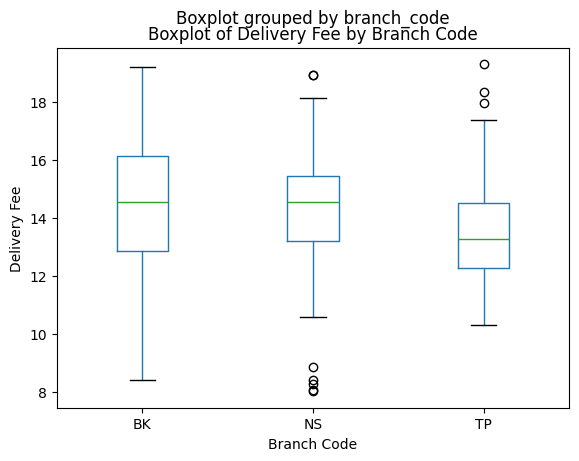

In [11]:
plt.figure(figsize=(10, 6))
df_outlier.boxplot(column="delivery_fee",by="branch_code",grid=False)
plt.title('Boxplot of Delivery Fee by Branch Code')
plt.xlabel('Branch Code')
plt.ylabel('Delivery Fee')
plt.xticks()
plt.show()

from the above boxplot, almost 80% of the outliers have been removed from the dataframe.

In [12]:
df_outlier.to_csv("109_Task1_outliers", index=False) # Writing the removed dataframe to the csv file